# Implementation of question number 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

# Define NN class

In [3]:
np.random.seed(42)

class WeightInitializer(object):
    def __init__(self):
        pass

    def initialize_weights(self, dims):
        pass

class ZeroInitializer(WeightInitializer):
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weights.append((np.zeros(dim[0]), np.zeros(dim)))

        return weights

class NormalInitializer(WeightInitializer):
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weights.append((np.zeros(dim[0]), np.random.normal(0.0, 1.0, dim)))

        return weights

class GlorotInitializer(WeightInitializer):
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weight_range = np.sqrt(6. / (dim[0] + dim[1]))
            weights.append((np.zeros(dim[0]), np.random.uniform(-weight_range, weight_range, size = dim)))

        return weights

# Currently this class only works with nets of exactly 2 hidden layers
class NN:
    def __init__(self, hidden_dims=(1024,2048), n_hidden=2, mode='train', weight_initer = GlorotInitializer(), 
        input_size = 2, output_size= 3):
        print("hidden dims inside NN is ", hidden_dims)
        self.hidden_dims = hidden_dims
        self.n_hidden = n_hidden
        self.weight_initer = weight_initer
        
        dims = [(hidden_dims[0], input_size), 
                (hidden_dims[1], hidden_dims[0]),
                (output_size, hidden_dims[1])]

        params = self.weight_initer.initialize_weights(dims)
        self.b1, self.W1 = params[0]
        self.b2, self.W2 = params[1]
        self.b3, self.W3 = params[2]
        self.parameters = [self.b1, self.W1, self.b2, self.W2, self.b3, self.W3]
        
    def forward(self, x):
        if len(x.shape) == 1:
            x = x[None]
        ha_1 = np.dot(x, self.W1.T) + self.b1
        hs_1 = self.activation(ha_1)
        
        ha_2 = np.dot(hs_1, self.W2.T) + self.b2
        hs_2 = self.activation(ha_2)
        
        oa = np.dot(hs_2, self.W3.T) + self.b3
        os = self.softmax(oa, axis=1)
        
        return ha_1, hs_1, ha_2, hs_2, oa, os

    def softmax(self, inp, axis = 1):
        e_x = np.exp(inp - np.max(inp, axis=axis, keepdims=True))
        return e_x / e_x.sum(axis=axis, keepdims=True)
    
    def backward(self, y, x, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay=0):
        if len(x.shape) == 1:
            x = x[None]
            
        bs = x.shape[0]
        dl_doa = os - y
        
        dl_dW3 = np.dot(dl_doa.T, hs_2) / bs + weight_decay * self.W3
        dl_db3 = dl_doa.mean(axis=0)
        
        dl_dhs_2 = np.dot(dl_doa, self.W3)
        dl_dha_2 = (ha_2 > 0) * dl_dhs_2
        
        dl_dW2 = np.dot(dl_dha_2.T, hs_1) / bs + weight_decay * self.W2
        dl_db2 = dl_dha_2.mean(axis=0)
        
        d1_dhs_1 = np.dot(dl_dha_2, self.W2)
        dl_dha_1 = (ha_1 > 0) * d1_dhs_1
        
        dl_dW1 = np.dot(dl_dha_1.T, x) / bs + weight_decay * self.W1
        dl_db1 = dl_dha_1.mean(axis=0)
        
        return dl_db1, dl_dW1, dl_db2, dl_dW2, dl_db3, dl_dW3
    
    def finite_diff(self, x, y, eps=1e-5):
        p = self.parameters[3]
        grad_fdiff = np.zeros(shape=p.shape)
        for index, v in np.ndenumerate(p):
            p[index] += eps
            _, _, _, _, _, os_plus = self.forward(x)
            loss_diff_plus = self.loss(os_plus, y)
            p[index] -= 2*eps
            _, _, _, _, _, os_minus = self.forward(x)
            loss_diff_minus = self.loss(os_minus, y)
            grad_fdiff[index] = (loss_diff_plus - loss_diff_minus) / float(2*eps)
            p[index] += eps
            
        #gradients_finite_diff.append(grad_fdiff)
        return grad_fdiff
    
    def activation(self, inp):
        return (inp > 0) * inp

    def loss(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)

    def update(self, grads, learning_rate):
        for p, grad in zip(self.parameters, grads):
            updt = learning_rate * grad
            p -= updt   
        
    def train(self, data, target, mb_size=100, learning_rate=1e-2, weight_decay=0.):
        for i in range(data.shape[0] // mb_size):
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            ha_1, hs_1, ha_2, hs_2, oa, os = self.forward(xi)
            average_grads = self.backward(yi, xi, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay)
            average_loss = self.loss(os, yi)
            self.update(average_grads, learning_rate)
        return average_loss
    
    def test(self, x, y):
        _, _, _, _, _, os = self.forward(x)
        return self.loss(os, y), os.argmax(axis=1)

# Loading Fashion MNIST

In [ ]:
# # Either put the fashionmnist folder in the current folder or uncomment the next line that will download it
# !git clone https://github.com/zalandoresearch/fashion-mnist fashionmnist
    
from fashionmnist.utils import mnist_reader
from random import shuffle

X_train, y_train = mnist_reader.load_mnist('fashionmnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashionmnist/data/fashion', kind='t10k')

indices = list(range(len(X_train)))
shuffle(indices)

X_train = X_train / 255
X_test = X_test / 255

# print(X_train[0])

X_valid, y_valid = X_train[indices[55000:]], y_train[indices[55000:]]
X_train, y_train = X_train[indices[:55000]], y_train[indices[:55000]]

y_train_onehot = onehot(y_train, 10)
y_valid_onehot = onehot(y_valid, 10)
y_test_onehot = onehot(y_test, 10)

# Train and test on fashionmnist with NN

In [ ]:
mlp = NN(hidden_dims = (512, 512), weight_initer = NormalInitializer(), input_size = 784, output_size = 10)

train_accuracies, train_losses = [], []
valid_accuracies, valid_losses = [], []
test_accuracies, test_losses = [], []
num_epochs = 5

for e in range(num_epochs):
    loss = mlp.train(X_train, y_train_onehot, mb_size=100)    
    loss_train, pred_train = mlp.test(X_train, y_train_onehot)
    loss_valid, pred_valid = mlp.test(X_valid, y_valid_onehot)
    loss_test, pred_test = mlp.test(X_test, y_test_onehot)
    valid_losses.append(loss_valid)
    test_losses.append(loss_test)
    valid_accuracies.append((pred_valid == y_valid).mean())
    test_accuracies.append((pred_test == y_test).mean())
    train_losses.append(loss_train)
    train_accuracies.append((pred_train == y_train).mean())

## Loss graph
plt.figure(figsize=(12, 4))
axis = plt.subplot(1, 2, 1)
axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
axis.plot(range(1, len(test_losses)+1), test_losses, label='test')
axis.legend()
axis.set_ylabel('Loss')
axis.set_xlabel('Epochs')

## Accuracy graph
axis = plt.subplot(1, 2, 2)
axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
axis.plot(range(1, len(test_accuracies)+1), test_accuracies, label='test')
axis.legend()
axis.set_ylabel('Accuracy')
axis.set_xlabel('Epochs')

plt.title("FashionMNIST")

# Loading MNIST dataset

In [4]:
from random import shuffle

# mnist_data = mnist_reader.load_mnist('mnist/raw/', kind='train')
mnist_data = np.load('/Users/akileshbadrinaaraayanan/Desktop/MILA_courses/Spring2019/IFT6135/assignment1/datasets/mnist.npy', encoding='latin1')

X_train, y_train = mnist_data[0]
X_valid, y_valid = mnist_data[1]
X_test, y_test = mnist_data[2]

X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test = X_test.astype("float32")

print('len X train ', len(X_train))
print('len y train ', len(y_train))
print('len X valid ', len(X_valid))
print('len y valid ', len(y_valid))
print('len X test ', len(X_test))
print('len y test ', len(y_test))

indices = list(range(len(X_train)))
shuffle(indices)

y_train_onehot = onehot(y_train, 10)
y_valid_onehot = onehot(y_valid, 10)
y_test_onehot = onehot(y_test, 10)

len X train  50000
len y train  50000
len X valid  10000
len y valid  10000
len X test  10000
len y test  10000


## Gradient checking and plot as required in question 

In [ ]:
import math

x1 = X_train[0]
y1 = y_train_onehot[0]

mlp = NN(hidden_dims = (512, 512), weight_initer = GlorotInitializer(), input_size = 784, output_size = 10)
ha_1, hs_1, ha_2, hs_2, oa, os = mlp.forward(x1)

# grab the true gradients for the weights of the first layer
true_gradients = mlp.backward(y1, x1, ha_1, hs_1, ha_2, hs_2, oa, os)


In [ ]:
possible_epsilon = []
N_list = []
for k in range(1,6):
    for i in range(6):
        possible_epsilon.append(1 / float(k * math.pow(10, i)))

possible_epsilon = sorted(possible_epsilon)
N_list = [(1/float(i)) for i in possible_epsilon] 
max_diff_list = []

for epsilon in possible_epsilon:
    finite_diff_grad = mlp.finite_diff(x1,y1, eps=epsilon)
    difference = np.abs(finite_diff_grad.flatten()[:10] - true_gradients[3].flatten()[:10])
    max_diff = np.max(difference)
    max_diff_list.append(max_diff)


In [ ]:
fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 14 and height to 10
fig_size[0] = 14
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.handlelength"] = 2
plt.rcParams["axes.titlesize"] = 'large'
plt.rcParams["axes.labelsize"] = 'medium'

def plot_max_diff_grad(eps_list, max_diff_list):
    plt.xlabel('epsilon ')
    plt.ylabel('Max difference : True gradient - Finite difference gradient ')
    plt.plot(eps_list, max_diff_list)

def plot_max_diff_grad_N(N_list, max_diff_list):
    plt.xlabel('N ')
    plt.ylabel('Max difference : True gradient - Finite difference gradient ')
    plt.plot(N_list, max_diff_list)


    

#plot_max_diff_grad(possible_epsilon[-10:], max_diff_list[-10:])
plot_max_diff_grad_N(N_list[-10:], max_diff_list[-10:])


# Compute train/valid/test loss and accuracy and display training curves

hidden dims inside NN is  (512, 512)


Text(0.5, 0, 'Epochs')

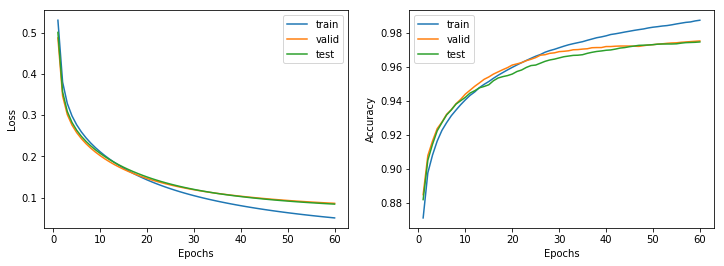

In [6]:
mlp = NN(hidden_dims = (512, 512), weight_initer = GlorotInitializer(), input_size = 784, output_size = 10)

train_accuracies, train_losses = [], []
valid_accuracies, valid_losses = [], []
test_accuracies, test_losses = [], []
num_epochs = 60

for e in range(num_epochs):
    
    loss = mlp.train(X_train, y_train_onehot, mb_size=100)
    loss_train, pred_train = mlp.test(X_train, y_train_onehot)
    loss_valid, pred_valid = mlp.test(X_valid, y_valid_onehot)
    loss_test, pred_test = mlp.test(X_test, y_test_onehot)
    
    valid_losses.append(loss_valid)
    test_losses.append(loss_test)
    valid_accuracies.append((pred_valid == y_valid).mean())
    test_accuracies.append((pred_test == y_test).mean())
    train_losses.append(loss_train)
    train_accuracies.append((pred_train == y_train).mean())

## Loss figure
plt.figure(figsize=(12, 4))
axis = plt.subplot(1, 2, 1)
axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
axis.plot(range(1, len(test_losses)+1), test_losses, label='test')
axis.legend()
axis.set_ylabel('Loss')
axis.set_xlabel('Epochs')

## Accuracy figure
axis = plt.subplot(1, 2, 2)
axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
axis.plot(range(1, len(test_accuracies)+1), test_accuracies, label='test')
axis.legend()
axis.set_ylabel('Accuracy')
axis.set_xlabel('Epochs')

In [8]:
print(test_accuracies[59])

0.9746
